In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, GlobalAveragePooling2D, Add, Input, BatchNormalization, ReLU
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Datasets/AIyurveda'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = tf.keras.utils.image_dataset_from_directory(data_path)

# Resize images to (224, 224)
def resize_image(image, label):
    image = tf.image.resize(image, (256, 256))
    return image, label

data = data.map(resize_image)

# One-hot encode the labels
data = data.map(lambda x, y: (x, tf.one_hot(y, depth=23)))

# Preprocess the data
data = data.map(lambda x, y: (x / 255, y))

Found 5844 files belonging to 2 classes.


In [9]:
# Split data
train_size = int(len(data) * .7)
val_size = int(len(data) * .2) + 1
test_size = int(len(data) * .1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [10]:
def residual_block(x, filters, stride=1):
    shortcut = x

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut if the input and output shapes are different
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

input_layer = Input(shape=(256, 256, 3))

# Initial convolution and max pooling layers
x = Conv2D(64, (7, 7), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

# ResNet18 architecture (4 residual blocks)
x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)

# Global average pooling and output layers
x = GlobalAveragePooling2D()(x)
output_layer = Dense(23, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 128, 128, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ re_lu_17[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 64, 64, 64)     │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 64, 64, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 64, 64, 64)     │              0 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ re_lu_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 64, 64, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ re_lu_20[0][0]         │
├──────────────────────

 Total params: 11,199,127 (42.72 MB)

 Trainable params: 11,191,319 (42.69 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [12]:
# Train the model
history = model.fit(train, epochs=10, validation_data=val)

# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2175s 17s/step - accuracy: 0.7356 - loss: 0.9950 - precision_1: 0.7606 - recall_1: 0.7345 - val_accuracy: 0.7956 - val_loss: 0.5720 - val_precision_1: 0.7956 - val_recall_1: 0.7956
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2109s 16s/step - accuracy: 0.7920 - loss: 0.5314 - precision_1: 0.7920 - recall_1: 0.7920 - val_accuracy: 0.7981 - val_loss: 0.5162 - val_precision_1: 0.7981 - val_recall_1: 0.7981
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2130s 17s/step - accuracy: 0.7993 - loss: 0.5199 - precision_1: 0.7993 - recall_1: 0.7993 - val_accuracy: 0.7880 - val_loss: 0.5238 - val_precision_1: 0.7880 - val_recall_1: 0.7880
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2156s 16s/step - accuracy: 0.7923 - loss: 0.5190 - precision_1: 0.7923 - recall_1: 0.7923 - val_accuracy: 0.7889 - val_loss: 0.5564 - val_precision_1: 0.7889 - val_recall_1: 0.7889
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2252s 17s/step - accuracy: 0.7891 - loss: 0.5301 - precision_1: 0.7891 - rec

In [13]:
model.save('/content/drive/My Drive/Weights/AIyurveda.h5')
model.save_weights('/content/drive/My Drive/Weights/AIyurveda_weights.weights.h5')

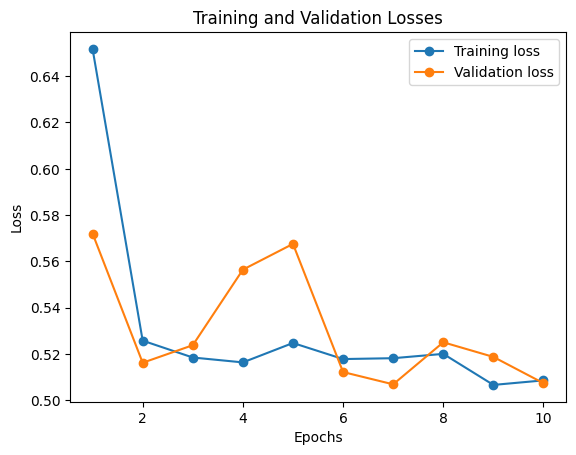

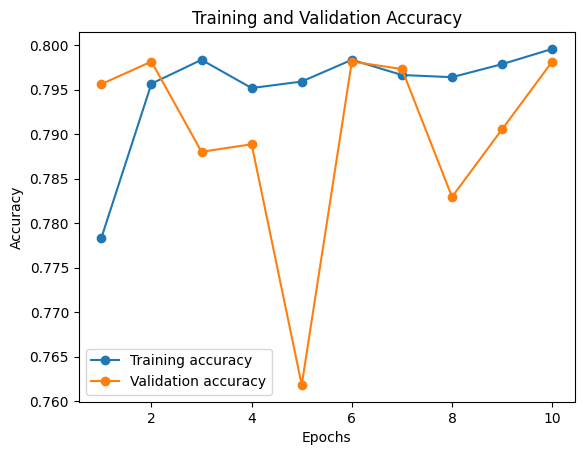

In [14]:
# Plot training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss', marker='o')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, label='Training accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()